# 3. Model proposals - DF3 (662x8)

LDA, QDA, K-NN, Naive Bayes, Logistic Regression, Decision Trees and Random Forests

### Libraries and data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
from sklearn.decomposition import PCA
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, KFold,
    cross_validate
)
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
import scipy.stats as stats
from scipy.stats import boxcox
from pandas.api.types import CategoricalDtype

from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
)
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
from IPython.core.interactiveshell import InteractiveShell
from sklearn.tree import DecisionTreeClassifier
#import graphviz
from sklearn.tree import export_graphviz
from sklearn.ensemble import (
    RandomForestClassifier, VotingClassifier, GradientBoostingClassifier,
    StackingClassifier, ExtraTreesClassifier
)
from imblearn.under_sampling import RandomUnderSampler
from time import time
from datetime import timedelta

InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.precision', 3)
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
DF3 = pd.read_pickle('RiskFactors_processed.pkl.bz2',compression='bz2')
selected_features = ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Smokes', 
                     'Hormonal Contraceptives', 'IUD', 'STDs:condylomatosis', 'STDs:HIV', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Cancer'] # Lasso extraction
DF3 = DF3[selected_features]
DF3 = DF3.drop(columns=['STDs:HIV', 'Dx:CIN','Dx:Cancer','Dx:HPV']) # We extract features from DT&RF
DF3.head()
DF3.shape
numerical_columns = ['Age', 'Number of sexual partners', 'First sexual intercourse']
categorical_columns = ['Smokes', 'Hormonal Contraceptives', 'STDs:condylomatosis', 'IUD']

,Age,Number of sexual partners,First sexual intercourse,Smokes,Hormonal Contraceptives,IUD,STDs:condylomatosis,Cancer
0,0.901,0.758,0.539,0,1,0,0,0
1,0.746,0.851,0.539,1,1,0,0,0
2,0.514,0.314,0.804,0,1,0,0,0
3,0.685,0.506,0.804,1,1,0,0,1
4,0.663,0.314,0.652,0,1,0,0,0


(662, 8)

## UNDER/OVER SAMPLING

We've decided to undersample the majority class (0 = patients without cancer) in order to adress class imbalance. Oversampling may affect negatively as random observations of patients with cancer are being generated artificially, which might not be accurate.

In [3]:
# Load the dataset and split into train, test, and validation sets
X = DF3.iloc[:, :-1]  # Features (all columns except the last one)
y = DF3['Cancer']  # Target variable (last column)

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Apply resampling techniques to handle class imbalance
undersampler = RandomUnderSampler(sampling_strategy=0.7,random_state=40)  # Adjust the sampling strategy as needed
X_train, y_train = undersampler.fit_resample(X_train, y_train)
X_train.shape, X_val.shape, X_test.shape

((123, 7), (133, 7), (133, 7))

In [4]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

In [5]:
def compute_metrics(y_real,y_pred):
    # By default it will compute the binary recall of class 1, we can specify which class do we want by using this parameter 
    recall_class_1 =recall_score(y_real,y_pred, pos_label=1)
    f1_class_1 =f1_score(y_real,y_pred, pos_label=1)
    accuracy = accuracy_score(y_real,y_pred)
    f1_macro =f1_score(y_real,y_pred, average='macro')
    precison_macro =precision_score(y_real,y_pred,  average='macro')
    recall_macro =recall_score(y_real,y_pred,  average='macro')
    return [recall_class_1, f1_class_1, accuracy,f1_macro,precison_macro,recall_macro ]

In [6]:
results = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])


#### LDA

In [7]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)


print('Priors:', lda_model.priors_)
print('Means:\n')
means = pd.DataFrame(lda_model.means_)
means.columns = DF3.columns[:-1]  # Exclude the target variable
means.index = lda_model.classes_
means

print('Coefficients:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = DF3.columns[:-1]  # Exclude the target variable
coefs.index = [0]  # Set a single index value for binary classification
coefs.T

print('Intercepts:')
intercepts = pd.DataFrame(lda_model.intercept_)
intercepts.index = [0]  # Set a single index value for binary classification
intercepts

print('Explained Variance Ratio:')
explained_variance_ratio = pd.DataFrame(lda_model.explained_variance_ratio_)
explained_variance_ratio

LinearDiscriminantAnalysis()

Priors: [0.58536585 0.41463415]
Means:



,Age,Number of sexual partners,First sexual intercourse,Smokes,Hormonal Contraceptives,IUD,STDs:condylomatosis
0,0.519,0.309,0.640,0.097,0.681,0.111,0.056
1,0.498,0.334,0.637,0.137,0.647,0.137,0.137


Coefficients:


,0
Age,-0.862
Number of sexual partners,0.471
First sexual intercourse,0.300
Smokes,0.346
Hormonal Contraceptives,-0.066
IUD,0.151
STDs:condylomatosis,0.949


Intercepts:


,0
0,-0.357


Explained Variance Ratio:


,0
0,1.0


In [8]:
confusion(pd.Series(y_val), pd.Series(y_pred_lda))

predicted,0,1
target,,
0,104,12
1,14,3


In [9]:
print(classification_report(y_val, y_pred_lda))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       116
           1       0.20      0.18      0.19        17

    accuracy                           0.80       133
   macro avg       0.54      0.54      0.54       133
weighted avg       0.79      0.80      0.80       133



In [10]:
results = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results.loc['LDA', :] = compute_metrics(y_val, y_pred_lda)
results

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.176,0.188,0.805,0.538,0.541,0.537


#### QDA

In [11]:
import warnings
warnings.filterwarnings("ignore")

index= pd.MultiIndex.from_arrays([[], []], names=('model', 'reg'));
results_qda = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro']);

regularization_parameters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1];

for reg in regularization_parameters:
    qda_model = QuadraticDiscriminantAnalysis(reg_param=reg);
    qda_model = qda_model.fit(X_train,y_train);
    y_pred = qda_model.predict(X_val);
    results_qda.loc[('QDA',reg), :] = compute_metrics(y_val, y_pred);

results_qda.sort_values(by='**Recall class 1**', ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro  \
model reg                                                             
QDA   1.000e-02              0.471           0.34    0.767    0.599   
      0.000e+00              0.412          0.292    0.744    0.568   
      1.000e-04              0.412          0.292    0.744    0.568   
      1.000e-03              0.412          0.298    0.752    0.574   
      1.000e-01              0.176          0.194    0.812    0.544   
      5.000e-01                0.0            0.0    0.872    0.466   
      1.000e+00                0.0            0.0    0.872    0.466   

                Precision Macro Recall Macro  
model reg                                     
QDA   1.000e-02            0.59         0.64  
      0.000e+00           0.564        0.602  
      1.000e-04           0.564        0.602  
      1.000e-03           0.568        0.607  
      1.000e-01           0.548        0.541  
      5.000e-01           0.436          0.5  
      1.000e+00           0.436          0.5

In [12]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=0.01);
qda_model = qda_model.fit(X_train,y_train);
y_pred_qda = qda_model.predict(X_val);

In [13]:
results.loc['QDA-0.01', :] = compute_metrics(y_val, y_pred_qda)
results

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.176,0.188,0.805,0.538,0.541,0.537
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64


#### $k$-NN

In [14]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'));
results_knn = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

k_values = range(1,50,2);

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k);
    knn = knn.fit(X_train,y_train);
    y_pred = knn.predict(X_val);
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred);

results_knn.sort_values(by='**Recall class 1**',ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro Precission Macro  \
model k                                                                         
KNN   5               0.706          0.289    0.556    0.483            0.554   
      1               0.647          0.286    0.586    0.497            0.551   
      3               0.647          0.265    0.541    0.466            0.539   
      7               0.529          0.257    0.609    0.496            0.535   
      9               0.471          0.254    0.647    0.511            0.535   
      11              0.353          0.222    0.684    0.512            0.524   
      15              0.294          0.238    0.759    0.548            0.544   
      13              0.235          0.174    0.714    0.501            0.506   
      17              0.235           0.19    0.744    0.519             0.52   
      19              0.235          0.195    0.752    0.524            0.524   
      21              0.176          0.167    0.774    0.518            0.518   
      33              0.176          0.231     0.85    0.574             0.61   
      31              0.118          0.148    0.827    0.526            0.539   
      35              0.059          0.091     0.85    0.504            0.537   
      25              0.059          0.074    0.812    0.485            0.485   
      27              0.059           0.08    0.827    0.492            0.498   
      23              0.059          0.071    0.805    0.481             0.48   
      29                0.0            0.0     0.82     0.45            0.433   
      37                0.0            0.0    0.857    0.462            0.435   
      39                0.0            0.0    0.872    0.466            0.436   
      41                0.0            0.0    0.872    0.466            0.436   
      43                0.0            0.0    0.865    0.464            0.436   
      45                0.0            0.0    0.865    0.464            0.436   
      47                0.0            0.0    0.872    0.466            0.436   
      49                0.0            0.0    0.872    0.466            0.436   

         Recall Macro  
model k                
KNN   5          0.62  
      1         0.612  
      3         0.586  
      7         0.575  
      9         0.572  
      11        0.543  
      15        0.561  
      13         0.51  
      17        0.527  
      19        0.531  
      21        0.519  
      33        0.562  
      31        0.524  
      35        0.512  
      25        0.491  
      27        0.499  
      23        0.486  
      29         0.47  
      37        0.491  
      39          0.5  
      41          0.5  
      43        0.496  
      45        0.496  
      47          0.5  
      49          0.5

In [15]:
knn = KNeighborsClassifier(n_neighbors=5);
knn = knn.fit(X_train,y_train);
y_pred_knn = knn.predict(X_val);
results.loc['KNN-5', :] = compute_metrics(y_val, y_pred_knn);
results.sort_values(by='**Recall class 1**',ascending=False)
confusion(pd.Series(y_val), pd.Series(y_pred_knn))

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
LDA,0.176,0.188,0.805,0.538,0.541,0.537


predicted,0,1
target,,
0,62,54
1,5,12


#### Naive Bayes

In [16]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train,y_train)
y_pred_gnb = gaussian_nb.predict(X_val);

results.loc['Gaussian-NB', :] = compute_metrics(y_val, y_pred_gnb);
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
LDA,0.176,0.188,0.805,0.538,0.541,0.537


In [17]:
# We need to load again our data so we can pre-process it differently
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

X_train_numerical = X_train[numerical_columns]
X_train_categorical = X_train[categorical_columns]

X_val_numerical = X_val[numerical_columns]
X_val_categorical = X_val[categorical_columns]

X_test_numerical = X_test[numerical_columns]
X_test_categorical = X_test[categorical_columns]

In [18]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train_numerical,y_train)
y_pred_gnb_num = gaussian_nb.predict(X_val_numerical);

results.loc['Gaussian-NB-only-numerical', :] = compute_metrics(y_val, y_pred_gnb_num);


cat_nb = CategoricalNB()
cat_nb = cat_nb.fit(X_train_categorical,y_train)
y_pred_gnb_cat = cat_nb.predict(X_val_categorical);

results.loc['Gaussian-NB-only-categorical', :] = compute_metrics(y_val, y_pred_gnb_cat);

results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
LDA,0.176,0.188,0.805,0.538,0.541,0.537
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5
Gaussian-NB-only-categorical,0.0,0.0,0.872,0.466,0.436,0.5


In [19]:
combined_prediction_proba= cat_nb.predict_proba(X_val_categorical) * gaussian_nb.predict_proba(X_val_numerical)

combined_prediction = np.argmax(combined_prediction_proba,axis=1)

results.loc['Combined-NB', :] = compute_metrics(y_val, combined_prediction);
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
LDA,0.176,0.188,0.805,0.538,0.541,0.537
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5
Gaussian-NB-only-categorical,0.0,0.0,0.872,0.466,0.436,0.5
Combined-NB,0.0,0.0,0.872,0.466,0.436,0.5


In [20]:
def only_cero_when_you_are_sure(x):
    if x[0] > 0.6:
        return 0
    else:
        return 1

combined_pred_tuned = pd.DataFrame(combined_prediction_proba).apply(only_cero_when_you_are_sure, axis=1)

results.loc['Combined-NB-tuned', :] = compute_metrics(y_val, combined_pred_tuned);

results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
LDA,0.176,0.188,0.805,0.538,0.541,0.537
Combined-NB-tuned,0.118,0.182,0.865,0.554,0.641,0.546
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5
Gaussian-NB-only-categorical,0.0,0.0,0.872,0.466,0.436,0.5
Combined-NB,0.0,0.0,0.872,0.466,0.436,0.5


#### Logistic regression

In [21]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'));
results_logreg = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C);
    logreg = logreg.fit(X_train,y_train);
    y_pred = logreg.predict(X_val);
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred);

results_logreg.sort_values(by='**Recall class 1**', ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro  \
model  C                                                              
LogReg 100000.0                0.0            0.0    0.872    0.466   
       10000.0                 0.0            0.0    0.872    0.466   
       1000.0                  0.0            0.0    0.872    0.466   
       100.0                   0.0            0.0    0.872    0.466   
       10.0                    0.0            0.0    0.872    0.466   
       1.0                     0.0            0.0    0.872    0.466   
       0.1                     0.0            0.0    0.872    0.466   

                Precission Macro Recall Macro  
model  C                                       
LogReg 100000.0            0.436          0.5  
       10000.0             0.436          0.5  
       1000.0              0.436          0.5  
       100.0               0.436          0.5  
       10.0                0.436          0.5  
       1.0                 0.436          0.5  
       0.1                 0.436          0.5

In [22]:
logreg = LogisticRegression(C=10.0).fit(X_train,y_train);
y_pred_logreg = logreg.predict(X_val);
results.loc['LogReg-10.0', :] = compute_metrics(y_val, y_pred_logreg)
results.sort_values(by='**Recall class 1**', ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
LDA,0.176,0.188,0.805,0.538,0.541,0.537
Combined-NB-tuned,0.118,0.182,0.865,0.554,0.641,0.546
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5
Gaussian-NB-only-categorical,0.0,0.0,0.872,0.466,0.436,0.5
Combined-NB,0.0,0.0,0.872,0.466,0.436,0.5
LogReg-10.0,0.0,0.0,0.872,0.466,0.436,0.5


After performing a feature selection with Extra Trees we found practically the same results, specially k-NN-3 stands out, but it's far from perfect.

#### Decision trees

In [23]:
model_tree = DecisionTreeClassifier().fit(X_train, y_train)

In [24]:
dot_data = export_graphviz(model_tree, out_file=None, 
                         feature_names=X_train.columns,  
                         class_names=['no', 'yes'],  
                         filled=True, rounded=True,  
                         special_characters=True, 
                         rotate=True,
                         proportion=True,
                         max_depth=3)  
#graph = graphviz.Source(dot_data)  
#graph 

In [25]:
y_pred = model_tree.predict(X_val)

results.loc['DT-default',:] = compute_metrics(y_val, y_pred)

confusion(pd.Series(y_val), pd.Series(y_pred))
results
print(classification_report(y_val, y_pred, target_names=['no', 'yes'],))

predicted,0,1
target,,
0,97,19
1,12,5


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.176,0.188,0.805,0.538,0.541,0.537
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5
Gaussian-NB-only-categorical,0.0,0.0,0.872,0.466,0.436,0.5
Combined-NB,0.0,0.0,0.872,0.466,0.436,0.5
Combined-NB-tuned,0.118,0.182,0.865,0.554,0.641,0.546
LogReg-10.0,0.0,0.0,0.872,0.466,0.436,0.5
DT-default,0.294,0.244,0.767,0.553,0.549,0.565


              precision    recall  f1-score   support

          no       0.89      0.84      0.86       116
         yes       0.21      0.29      0.24        17

    accuracy                           0.77       133
   macro avg       0.55      0.57      0.55       133
weighted avg       0.80      0.77      0.78       133



In [26]:
y_pred_train = model_tree.predict(X_train)

confusion(pd.Series(y_train),pd.Series(y_pred_train))

print(classification_report(y_train, y_pred_train, target_names=['no', 'yes'],))

predicted,0,1
target,,
0,345,0
1,4,47


              precision    recall  f1-score   support

          no       0.99      1.00      0.99       345
         yes       1.00      0.92      0.96        51

    accuracy                           0.99       396
   macro avg       0.99      0.96      0.98       396
weighted avg       0.99      0.99      0.99       396



In [27]:
print('Tree depht: {}\nNodes: {}'.format(model_tree.tree_.max_depth, model_tree.tree_.node_count))

Tree depht: 20
Nodes: 199


In [28]:
criterion = ['gini', 'entropy']

max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

init_time = time()
model_tree = DecisionTreeClassifier()

recall_class_1_scorer = make_scorer(recall_score, pos_label=1)
f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'recall_class_1': recall_class_1_scorer,
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=5,
                   return_train_score=False,
                   refit='f1_mac')

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:42.838574


In [29]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc', 'mean_test_recall_class_1'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc,mean_test_recall_class_1
955,entropy,20,log2,2,1,0.566,0.923,0.209,0.861,0.160
826,entropy,15,sqrt,1,2,0.563,0.893,0.233,0.813,0.216
550,entropy,None,log2,1,1,0.562,0.892,0.232,0.811,0.236
400,gini,20,auto,1,1,0.559,0.882,0.236,0.796,0.255
551,entropy,None,log2,1,2,0.557,0.902,0.213,0.826,0.198


In [30]:
best_params1 = model_5CV.best_params_
best_params1

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 1}

In [31]:
y_pred = model_5CV.predict(X_val)

results.loc['DT-best',:] = compute_metrics(y_val, y_pred)

confusion(pd.Series(y_val), pd.Series(y_pred))
results.sort_values(by='**Recall class 1**',ascending=False)

predicted,0,1
target,,
0,111,5
1,16,1


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
DT-default,0.294,0.244,0.767,0.553,0.549,0.565
LDA,0.176,0.188,0.805,0.538,0.541,0.537
Combined-NB-tuned,0.118,0.182,0.865,0.554,0.641,0.546
DT-best,0.059,0.087,0.842,0.5,0.52,0.508
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5
Gaussian-NB-only-categorical,0.0,0.0,0.872,0.466,0.436,0.5
Combined-NB,0.0,0.0,0.872,0.466,0.436,0.5


#### Random Forests

In [32]:
model_rf1 = RandomForestClassifier(oob_score=True).fit(X_train, y_train)

pred = model_rf1.predict(X_train)

confusion(pd.Series(y_train),pd.Series(pred))

print(classification_report(y_train, pred, target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf1.oob_score_)

predicted,0,1
target,,
0,344,1
1,3,48


              precision    recall  f1-score   support

          no       0.99      1.00      0.99       345
         yes       0.98      0.94      0.96        51

    accuracy                           0.99       396
   macro avg       0.99      0.97      0.98       396
weighted avg       0.99      0.99      0.99       396

OOB accuracy= 0.8409090909090909


In [33]:
y_pred = model_rf1.predict(X_val)
print('Validation Accuracy:{}'.format(model_rf1.score(X_val,y_val)))
results.loc['RF-default',:] = compute_metrics(y_val,y_pred)
confusion(pd.Series(y_val),pd.Series(y_pred))

Validation Accuracy:0.8345864661654135


predicted,0,1
target,,
0,110,6
1,16,1


In [34]:
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
DT-default,0.294,0.244,0.767,0.553,0.549,0.565
LDA,0.176,0.188,0.805,0.538,0.541,0.537
Combined-NB-tuned,0.118,0.182,0.865,0.554,0.641,0.546
DT-best,0.059,0.087,0.842,0.5,0.52,0.508
RF-default,0.059,0.083,0.835,0.496,0.508,0.504
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5
Gaussian-NB-only-categorical,0.0,0.0,0.872,0.466,0.436,0.5


In [35]:
model_rf2 = RandomForestClassifier(n_estimators=100, 
                                   oob_score=True, 
                                   class_weight='balanced').fit(X_train, y_train)

pred = model_rf2.predict(X_train)

confusion(pd.Series(y_train),pd.Series(pred))
print(classification_report(y_train,pred,target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf2.oob_score_)

predicted,0,1
target,,
0,342,3
1,1,50


              precision    recall  f1-score   support

          no       1.00      0.99      0.99       345
         yes       0.94      0.98      0.96        51

    accuracy                           0.99       396
   macro avg       0.97      0.99      0.98       396
weighted avg       0.99      0.99      0.99       396

OOB accuracy= 0.8484848484848485


We see predictions are great for training but bad for testing, we might be overfitting but this seems to be due to data imbalance.

In [36]:
y_pred = model_rf2.predict(X_val)

results.loc['RF-balance',:] = compute_metrics(y_val,y_pred)

confusion(pd.Series(y_val),pd.Series(y_pred))

predicted,0,1
target,,
0,112,4
1,16,1


In [37]:
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
DT-default,0.294,0.244,0.767,0.553,0.549,0.565
LDA,0.176,0.188,0.805,0.538,0.541,0.537
Combined-NB-tuned,0.118,0.182,0.865,0.554,0.641,0.546
DT-best,0.059,0.087,0.842,0.5,0.52,0.508
RF-default,0.059,0.083,0.835,0.496,0.508,0.504
RF-balance,0.059,0.091,0.85,0.504,0.537,0.512
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


In [38]:
init_time = time()

rf_model = RandomForestClassifier()

ntrees = [200,None]
max_depth = [100,None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf, 
                       'class_weight':balance
                   },
                   cv=5,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:07.231919


In [39]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc', 'mean_test_recall_class_1'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc,mean_test_recall_class_1
34,100,4,6,0.541,0.891,0.191,0.808,0.198
32,100,4,4,0.532,0.888,0.176,0.803,0.178
24,None,4,4,0.531,0.886,0.175,0.801,0.178
20,100,6,4,0.531,0.874,0.187,0.783,0.218
38,100,6,6,0.531,0.872,0.189,0.780,0.218


In [40]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced_subsample',
 'max_depth': 100,
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'n_estimators': 200}

In [41]:
rf_model_tuned = RandomForestClassifier(**best_params)
rf_model_tuned.fit(X_train, y_train)

y_pred = rf_model_tuned.predict(X_val)

results.loc['RF-best', :] = compute_metrics(y_val, y_pred)

results.sort_values(by='**Recall class 1**',ascending=False)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=100,
                       min_samples_leaf=4, min_samples_split=6,
                       n_estimators=200)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
DT-default,0.294,0.244,0.767,0.553,0.549,0.565
LDA,0.176,0.188,0.805,0.538,0.541,0.537
Combined-NB-tuned,0.118,0.182,0.865,0.554,0.641,0.546
RF-best,0.118,0.138,0.812,0.516,0.521,0.516
DT-best,0.059,0.087,0.842,0.5,0.52,0.508
RF-default,0.059,0.083,0.835,0.496,0.508,0.504
RF-balance,0.059,0.091,0.85,0.504,0.537,0.512


In [42]:
confusion(pd.Series(y_val),pd.Series(y_pred))

predicted,0,1
target,,
0,106,10
1,15,2


In [43]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)

y_pred = extra_trees.predict(X_val)

results.loc['extra_trees',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='**Recall class 1**',ascending=False)

ExtraTreesClassifier()

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
DT-default,0.294,0.244,0.767,0.553,0.549,0.565
LDA,0.176,0.188,0.805,0.538,0.541,0.537
Combined-NB-tuned,0.118,0.182,0.865,0.554,0.641,0.546
RF-best,0.118,0.138,0.812,0.516,0.521,0.516
extra_trees,0.118,0.148,0.827,0.526,0.539,0.524
DT-best,0.059,0.087,0.842,0.5,0.52,0.508
RF-default,0.059,0.083,0.835,0.496,0.508,0.504


In [44]:
init_time = time()

rf_model = ExtraTreesClassifier(class_weight='balanced')

ntrees = [150, None]
max_depth = [100, None]
min_samples_split = [4, 6]
min_samples_leaf = [2, 4]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'class_weight': balance
                   },
                   cv=5,
                   return_train_score=True,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:03.980681


In [45]:
pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc,mean_test_recall_class_1
40,None,2,4,0.527,0.862,0.193,0.765,0.238
32,100,2,4,0.523,0.871,0.174,0.778,0.198
16,100,2,4,0.522,0.868,0.176,0.773,0.196
24,None,2,4,0.518,0.866,0.171,0.770,0.198
34,100,2,6,0.518,0.857,0.178,0.758,0.216


In [46]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced_subsample',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 150}

In [47]:
extra_trees_best = ExtraTreesClassifier(**best_params)
extra_trees_best.fit(X_train,y_train)

y_pred = extra_trees_best.predict(X_val)

results.loc['extra_trees-best',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='**Recall class 1**',ascending=False)
confusion(pd.Series(y_val), pd.Series(y_pred))

ExtraTreesClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                     min_samples_split=4, n_estimators=150)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
DT-default,0.294,0.244,0.767,0.553,0.549,0.565
LDA,0.176,0.188,0.805,0.538,0.541,0.537
Combined-NB-tuned,0.118,0.182,0.865,0.554,0.641,0.546
RF-best,0.118,0.138,0.812,0.516,0.521,0.516
extra_trees,0.118,0.148,0.827,0.526,0.539,0.524
DT-best,0.059,0.087,0.842,0.5,0.52,0.508
RF-default,0.059,0.083,0.835,0.496,0.508,0.504


predicted,0,1
target,,
0,99,17
1,16,1


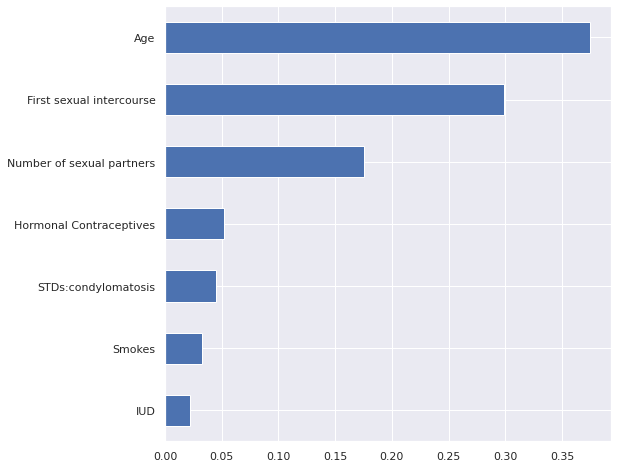

In [48]:
var_imp = pd.DataFrame({'importance': rf_model_tuned.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False);

## Results

In [49]:
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.289,0.556,0.483,0.554,0.62
QDA-0.01,0.471,0.34,0.767,0.599,0.59,0.64
Gaussian-NB,0.412,0.35,0.805,0.617,0.607,0.637
DT-default,0.294,0.244,0.767,0.553,0.549,0.565
LDA,0.176,0.188,0.805,0.538,0.541,0.537
Combined-NB-tuned,0.118,0.182,0.865,0.554,0.641,0.546
RF-best,0.118,0.138,0.812,0.516,0.521,0.516
extra_trees,0.118,0.148,0.827,0.526,0.539,0.524
DT-best,0.059,0.087,0.842,0.5,0.52,0.508
RF-default,0.059,0.083,0.835,0.496,0.508,0.504


### RF with another feature selection from DT&RF

In [50]:
DF3_aux = DF3.drop(columns=['Smokes', 'IUD'])
DF3.head()

,Age,Number of sexual partners,First sexual intercourse,Smokes,Hormonal Contraceptives,IUD,STDs:condylomatosis,Cancer
0,0.901,0.758,0.539,0,1,0,0,0
1,0.746,0.851,0.539,1,1,0,0,0
2,0.514,0.314,0.804,0,1,0,0,0
3,0.685,0.506,0.804,1,1,0,0,1
4,0.663,0.314,0.652,0,1,0,0,0


In [51]:
# Load the dataset and split into train, test, and validation sets
X = DF3_aux.iloc[:, :-1]  # Features (all columns except the last one)
y = DF3_aux['Cancer']  # Target variable (last column)

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Apply resampling techniques to handle class imbalance
undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=40)  # Adjust the sampling strategy as needed
X_train, y_train = undersampler.fit_resample(X_train, y_train)
X_train.shape, X_val.shape, X_test.shape

((123, 5), (133, 5), (133, 5))

In [52]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

In [53]:
def compute_metrics(y_real,y_pred):
    # By default it will compute the binary recall of class 1, we can specify which class do we want by using this parameter 
    recall_class_1 =recall_score(y_real,y_pred, pos_label=1)
    f1_class_1 =f1_score(y_real,y_pred, pos_label=1)
    accuracy = accuracy_score(y_real,y_pred)
    f1_macro =f1_score(y_real,y_pred, average='macro')
    precison_macro =precision_score(y_real,y_pred,  average='macro')
    recall_macro =recall_score(y_real,y_pred,  average='macro')
    return [recall_class_1, f1_class_1, accuracy,f1_macro,precison_macro,recall_macro ]

In [54]:
results = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])


In [55]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'));
results_knn = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

k_values = range(1,50,2);

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k);
    knn = knn.fit(X_train,y_train);
    y_pred = knn.predict(X_val);
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred);

results_knn.sort_values(by='**Recall class 1**',ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro Precission Macro  \
model k                                                                         
KNN   3               0.529           0.22    0.519    0.436             0.51   
      5               0.471          0.229    0.594    0.477            0.519   
      7               0.471          0.232    0.602    0.481            0.521   
      11              0.412          0.226    0.639    0.495            0.521   
      1               0.353          0.176    0.579    0.447            0.492   
      9               0.353          0.182    0.594    0.456            0.496   
      13              0.294          0.175    0.647    0.475            0.498   
      19              0.294           0.25    0.774    0.559            0.554   
      15              0.235          0.174    0.714    0.501            0.506   
      17              0.235          0.186    0.737    0.515            0.516   
      21              0.176          0.154    0.752    0.504            0.505   
      23              0.176          0.167    0.774    0.518            0.518   
      29              0.176          0.286    0.887    0.612            0.821   
      31              0.176          0.273     0.88    0.604            0.745   
      35              0.118            0.2     0.88    0.567            0.776   
      37              0.118           0.19    0.872    0.561            0.692   
      25              0.118          0.174    0.857    0.548            0.608   
      33              0.118            0.2     0.88    0.567            0.776   
      27              0.118          0.182    0.865    0.554            0.641   
      39              0.059          0.105    0.872    0.518            0.689   
      41                0.0            0.0    0.872    0.466            0.436   
      43                0.0            0.0    0.872    0.466            0.436   
      45                0.0            0.0    0.872    0.466            0.436   
      47                0.0            0.0    0.872    0.466            0.436   
      49                0.0            0.0    0.872    0.466            0.436   

         Recall Macro  
model k                
KNN   3         0.523  
      5         0.541  
      7         0.546  
      11        0.542  
      1         0.483  
      9         0.491  
      13        0.496  
      19        0.569  
      15         0.51  
      17        0.523  
      21        0.506  
      23        0.519  
      29        0.584  
      31         0.58  
      35        0.555  
      37         0.55  
      25        0.542  
      33        0.555  
      27        0.546  
      39        0.525  
      41          0.5  
      43          0.5  
      45          0.5  
      47          0.5  
      49          0.5

In [56]:
knn = KNeighborsClassifier(n_neighbors=3);
knn = knn.fit(X_train,y_train);
y_pred_knn = knn.predict(X_val);
results.loc['KNN-3', :] = compute_metrics(y_val, y_pred_knn);
results.sort_values(by='**Recall class 1**',ascending=False)
confusion(pd.Series(y_val), pd.Series(y_pred_knn))

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-3,0.529,0.22,0.519,0.436,0.51,0.523


predicted,0,1
target,,
0,60,56
1,8,9


In [57]:
model_tree = DecisionTreeClassifier().fit(X_train, y_train)

In [58]:
dot_data = export_graphviz(model_tree, out_file=None, 
                         feature_names=X_train.columns,  
                         class_names=['no', 'yes'],  
                         filled=True, rounded=True,  
                         special_characters=True, 
                         rotate=True,
                         proportion=True,
                         max_depth=3)  
#graph = graphviz.Source(dot_data)  
#graph 

In [59]:
y_pred = model_tree.predict(X_val)

results.loc['DT-default',:] = compute_metrics(y_val, y_pred)

confusion(pd.Series(y_val), pd.Series(y_pred))
results
print(classification_report(y_val, y_pred, target_names=['no', 'yes'],))

predicted,0,1
target,,
0,68,48
1,11,6


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-3,0.529,0.22,0.519,0.436,0.51,0.523
DT-default,0.353,0.169,0.556,0.433,0.486,0.47


              precision    recall  f1-score   support

          no       0.86      0.59      0.70       116
         yes       0.11      0.35      0.17        17

    accuracy                           0.56       133
   macro avg       0.49      0.47      0.43       133
weighted avg       0.76      0.56      0.63       133



In [60]:
y_pred_train = model_tree.predict(X_train)

confusion(pd.Series(y_train),pd.Series(y_pred_train))

print(classification_report(y_train, y_pred_train, target_names=['no', 'yes'],))

predicted,0,1
target,,
0,72,0
1,2,49


              precision    recall  f1-score   support

          no       0.97      1.00      0.99        72
         yes       1.00      0.96      0.98        51

    accuracy                           0.98       123
   macro avg       0.99      0.98      0.98       123
weighted avg       0.98      0.98      0.98       123



In [61]:
print('Tree depht: {}\nNodes: {}'.format(model_tree.tree_.max_depth, model_tree.tree_.node_count))

Tree depht: 14
Nodes: 99


In [62]:
criterion = ['gini', 'entropy']

max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

init_time = time()
model_tree = DecisionTreeClassifier()

recall_class_1_scorer = make_scorer(recall_score, pos_label=1)
f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'recall_class_1': recall_class_1_scorer,
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=5,
                   return_train_score=False,
                   refit='f1_mac')

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:40.684556


In [63]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc', 'mean_test_recall_class_1'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc,mean_test_recall_class_1
338,gini,15,sqrt,3,4,0.611,0.702,0.519,0.634,0.473
408,gini,20,auto,2,4,0.609,0.704,0.514,0.635,0.489
922,entropy,20,auto,5,3,0.606,0.722,0.490,0.651,0.473
763,entropy,10,log2,3,4,0.603,0.729,0.476,0.649,0.411
527,entropy,None,sqrt,1,3,0.602,0.672,0.532,0.618,0.531


In [64]:
best_params1 = model_5CV.best_params_
best_params1

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 4}

In [65]:
y_pred = model_5CV.predict(X_val)

results.loc['DT-best',:] = compute_metrics(y_val, y_pred)

confusion(pd.Series(y_val), pd.Series(y_pred))
results.sort_values(by='**Recall class 1**',ascending=False)

predicted,0,1
target,,
0,79,37
1,14,3


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-3,0.529,0.22,0.519,0.436,0.51,0.523
DT-default,0.353,0.169,0.556,0.433,0.486,0.47
DT-best,0.176,0.105,0.617,0.431,0.462,0.429


#### Random Forests

In [66]:
model_rf1 = RandomForestClassifier(oob_score=True).fit(X_train, y_train)

pred = model_rf1.predict(X_train)

confusion(pd.Series(y_train),pd.Series(pred))

print(classification_report(y_train, pred, target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf1.oob_score_)

predicted,0,1
target,,
0,70,2
1,0,51


              precision    recall  f1-score   support

          no       1.00      0.97      0.99        72
         yes       0.96      1.00      0.98        51

    accuracy                           0.98       123
   macro avg       0.98      0.99      0.98       123
weighted avg       0.98      0.98      0.98       123

OOB accuracy= 0.5934959349593496


In [67]:
y_pred = model_rf1.predict(X_val)
print('Validation Accuracy:{}'.format(model_rf1.score(X_val,y_val)))
results.loc['RF-default',:] = compute_metrics(y_val,y_pred)
confusion(pd.Series(y_val),pd.Series(y_pred))

Validation Accuracy:0.6090225563909775


predicted,0,1
target,,
0,76,40
1,12,5


In [68]:
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-3,0.529,0.22,0.519,0.436,0.51,0.523
DT-default,0.353,0.169,0.556,0.433,0.486,0.47
RF-default,0.294,0.161,0.609,0.453,0.487,0.475
DT-best,0.176,0.105,0.617,0.431,0.462,0.429


In [69]:
model_rf2 = RandomForestClassifier(n_estimators=100, 
                                   oob_score=True, 
                                   class_weight='balanced').fit(X_train, y_train)

pred = model_rf2.predict(X_train)

confusion(pd.Series(y_train),pd.Series(pred))
print(classification_report(y_train,pred,target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf2.oob_score_)

predicted,0,1
target,,
0,71,1
1,1,50


              precision    recall  f1-score   support

          no       0.99      0.99      0.99        72
         yes       0.98      0.98      0.98        51

    accuracy                           0.98       123
   macro avg       0.98      0.98      0.98       123
weighted avg       0.98      0.98      0.98       123

OOB accuracy= 0.5691056910569106


In [70]:
y_pred = model_rf2.predict(X_val)

results.loc['RF-balance',:] = compute_metrics(y_val,y_pred)

confusion(pd.Series(y_val),pd.Series(y_pred))

predicted,0,1
target,,
0,74,42
1,13,4


In [71]:
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-3,0.529,0.22,0.519,0.436,0.51,0.523
DT-default,0.353,0.169,0.556,0.433,0.486,0.47
RF-default,0.294,0.161,0.609,0.453,0.487,0.475
RF-balance,0.235,0.127,0.586,0.428,0.469,0.437
DT-best,0.176,0.105,0.617,0.431,0.462,0.429


In [72]:
init_time = time()

rf_model = RandomForestClassifier()

ntrees = [200,None]
max_depth = [100,None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf, 
                       'class_weight':balance
                   },
                   cv=5,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:07.883900


In [73]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc', 'mean_test_recall_class_1'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc,mean_test_recall_class_1
2,100,4,6,0.526,0.687,0.365,0.586,0.313
10,None,4,6,0.523,0.698,0.349,0.593,0.291
8,None,4,4,0.523,0.711,0.335,0.602,0.271
0,100,4,4,0.509,0.692,0.327,0.586,0.273
40,None,4,4,0.503,0.628,0.378,0.544,0.369


In [74]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': None,
 'max_depth': 100,
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'n_estimators': 200}

In [75]:
rf_model_tuned = RandomForestClassifier(**best_params)
rf_model_tuned.fit(X_train, y_train)

y_pred = rf_model_tuned.predict(X_val)

results.loc['RF-best', :] = compute_metrics(y_val, y_pred)

results.sort_values(by='**Recall class 1**',ascending=False)

RandomForestClassifier(max_depth=100, min_samples_leaf=4, min_samples_split=6,
                       n_estimators=200)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-3,0.529,0.22,0.519,0.436,0.51,0.523
DT-default,0.353,0.169,0.556,0.433,0.486,0.47
RF-default,0.294,0.161,0.609,0.453,0.487,0.475
RF-balance,0.235,0.127,0.586,0.428,0.469,0.437
DT-best,0.176,0.105,0.617,0.431,0.462,0.429
RF-best,0.176,0.122,0.677,0.462,0.478,0.463


In [76]:
confusion(pd.Series(y_val),pd.Series(y_pred))

predicted,0,1
target,,
0,87,29
1,14,3


In [77]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)

y_pred = extra_trees.predict(X_val)

results.loc['extra_trees',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='**Recall class 1**',ascending=False)

ExtraTreesClassifier()

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-3,0.529,0.22,0.519,0.436,0.51,0.523
extra_trees,0.471,0.239,0.617,0.491,0.526,0.554
DT-default,0.353,0.169,0.556,0.433,0.486,0.47
RF-default,0.294,0.161,0.609,0.453,0.487,0.475
RF-balance,0.235,0.127,0.586,0.428,0.469,0.437
DT-best,0.176,0.105,0.617,0.431,0.462,0.429
RF-best,0.176,0.122,0.677,0.462,0.478,0.463


In [78]:
init_time = time()

rf_model = ExtraTreesClassifier(class_weight='balanced')

ntrees = [150, None]
max_depth = [100, None]
min_samples_split = [4, 6]
min_samples_leaf = [2, 4]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'class_weight': balance
                   },
                   cv=5,
                   return_train_score=True,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:03.367416


In [79]:
pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc,mean_test_recall_class_1
44,None,4,4,0.503,0.606,0.400,0.536,0.407
18,100,2,6,0.496,0.583,0.409,0.520,0.413
10,None,2,6,0.493,0.672,0.314,0.560,0.255
38,100,4,6,0.491,0.593,0.389,0.527,0.407
28,None,4,4,0.490,0.592,0.389,0.520,0.387


In [80]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced_subsample',
 'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 150}

### Results for RF with another feature selection

In [81]:
extra_trees_best = ExtraTreesClassifier(**best_params)
extra_trees_best.fit(X_train,y_train)

y_pred = extra_trees_best.predict(X_val)

results.loc['extra_trees-best',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='**Recall class 1**',ascending=False)

ExtraTreesClassifier(class_weight='balanced_subsample', min_samples_leaf=4,
                     min_samples_split=4, n_estimators=150)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-3,0.529,0.22,0.519,0.436,0.51,0.523
extra_trees-best,0.529,0.25,0.594,0.486,0.531,0.566
extra_trees,0.471,0.239,0.617,0.491,0.526,0.554
DT-default,0.353,0.169,0.556,0.433,0.486,0.47
RF-default,0.294,0.161,0.609,0.453,0.487,0.475
RF-balance,0.235,0.127,0.586,0.428,0.469,0.437
DT-best,0.176,0.105,0.617,0.431,0.462,0.429
RF-best,0.176,0.122,0.677,0.462,0.478,0.463


### Testing the best model

In [82]:
X = DF3.iloc[:, :-1]  # Features (all columns except the last one)
y = DF3['Cancer']  # Target variable (last column)

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=40) # Adjust the sampling strategy as needed
X_train, y_train = undersampler.fit_resample(X_train, y_train)

results_test = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

In [83]:
knn = KNeighborsClassifier(n_neighbors=5);
knn = knn.fit(X_train,y_train);

# Predict the target variable for the validation set
y_pred_knn_val = knn.predict(X_val)
results_test.loc['KNN-5-val', :] = compute_metrics(y_val, y_pred_knn_val);
confusion(pd.Series(y_val), pd.Series(y_pred_knn_val))

# Predict the target variable for the test set
y_pred_knn_test = knn.predict(X_test)
results_test.loc['KNN-5-test', :] = compute_metrics(y_test, y_pred_knn_test);
confusion(pd.Series(y_test), pd.Series(y_pred_knn_test))

results_test.sort_values(by='**Recall class 1**',ascending=False)

predicted,0,1
target,,
0,62,54
1,5,12


predicted,0,1
target,,
0,74,42
1,9,8


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5-val,0.706,0.289,0.556,0.483,0.554,0.62
KNN-5-test,0.471,0.239,0.617,0.491,0.526,0.554
